# Reproject ERA5 data and combine datasets

## Installing packages

In [1]:
!pip install zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 16.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=e96fbd1f476249f0dc0f452f0afff4f2d8ba4cbec96addfe1f5df02ed7613ffb
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [2]:
!pip install rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 65.8 MB/s eta 0:00:00


## Downloading all needed data from Google Drive

Note: Both `concentration-osi-saf.nc.gz` and `concentration-osi-saf-preprocessed.nc.gz` are needed because the preprocessed one doesn't contain geographic information.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/Reanalysis/era5-monthly.zarr.tar era5-monthly.zarr.tar
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/Reanalysis/sst-test.grib sst-test.grib
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/Sea\ ice\ concentration/concentration-osi-saf.nc.gz concentration-osi-saf.nc.gz
!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/Sea\ ice\ concentration/concentration-osi-saf-preprocessed.nc.gz concentration-osi-saf-preprocessed.nc.gz

drive.flush_and_unmount()

Mounted at /content/drive


## Loading ERA5 data

In [4]:
!tar -xf era5-monthly.zarr.tar

In [5]:
import xarray as xr

In [6]:
data = xr.open_zarr('era5-monthly.zarr', decode_coords='all')

## Getting and writing geographic information from ERA5 data

In [7]:
import rioxarray

In [8]:
# this file is just for getting geographic information from rioxarray since rioxarray can't open .zarr files
src_data = rioxarray.open_rasterio('sst-test.grib')

In [9]:
src_crs = src_data.rio.crs
src_transform = src_data.rio.transform(recalc=True)

In [10]:
written_data = data.rio.write_crs(src_crs).rio.write_transform(src_transform)

## Getting geographic information from SIC data

In [11]:
!gzip -d concentration-osi-saf.nc.gz

In [12]:
# no idea why it gives 2 datasets
dst_data = rioxarray.open_rasterio('concentration-osi-saf.nc', decode_times=False)[0]['ice_conc']

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [13]:
dst_crs = dst_data.rio.crs
dst_transform = dst_data.rio.transform(recalc=True)

## Reprojecting ERA5 data

In [14]:
from rasterio.enums import Resampling

In [15]:
%%time
reprojected = written_data.rio.reproject(dst_crs, shape=(432, 432), transform=dst_transform, resampling=Resampling.bilinear)

CPU times: user 8min 48s, sys: 58.1 s, total: 9min 46s
Wall time: 10min 47s


In [16]:
# either the reprojecting or the storing as Zarr turns coordinates into data variables, so remove these since they're not very useful anyways.
coords = frozenset(written_data.coords) - frozenset(written_data.dims)
reprojected_2 = reprojected.drop_vars(coords)

In [17]:
# rename for consistency with SIC data
era5_data = reprojected_2.rename_dims({'x': 'xc', 'y': 'yc'}).rename_vars({'x': 'xc', 'y': 'yc'})

In [18]:
era5_data_chunked = era5_data.chunk({'time': 1})

## Combining ERA5 and SIC data

In [19]:
!gzip -d concentration-osi-saf-preprocessed.nc.gz

In [20]:
sic_data = xr.load_dataset('concentration-osi-saf-preprocessed.nc').chunk({'time': 1})

In [21]:
merged = xr.merge((sic_data, era5_data_chunked), join='inner')

## Saving the results

In [22]:
merged.to_zarr('sic-and-era5.zarr')

In [23]:
!tar -cf sic-and-era5.zarr.tar sic-and-era5.zarr

In [24]:
!du -h sic-and-era5.zarr.tar

4.3G	sic-and-era5.zarr.tar


In [25]:
drive.mount('/content/drive')

!cp sic-and-era5.zarr.tar drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/Combined/sic-and-era5.zarr.tar

drive.flush_and_unmount()

Mounted at /content/drive


# Plotting reprojected data

In [ ]:
import pandas as pd

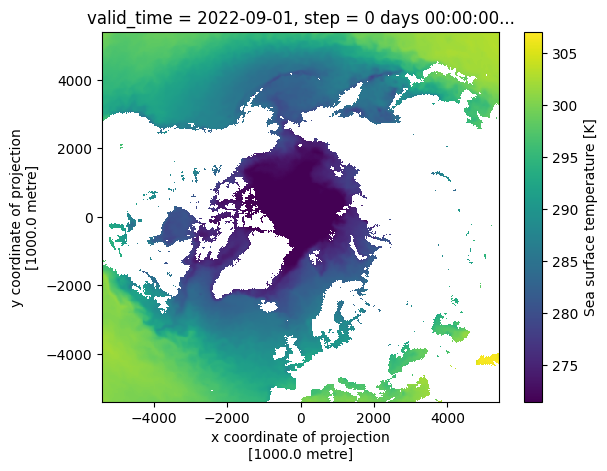

In [ ]:
reprojected['sst'].sel(time=pd.to_datetime('2022-09-01')).plot();

In [ ]:
# maybe force the reprojected ones to have the exact same land mask as SIC?

In [ ]:
reprojected

<xarray.Dataset>
Dimensions:      (x: 432, y: 432, time: 546)
Coordinates:
  * x            (x) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * y            (y) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    valid_time   (time) datetime64[ns] 1978-01-01 1978-02-01 ... 2023-06-01
    step         timedelta64[ns] 00:00:00
    surface      float64 0.0
  * time         (time) datetime64[ns] 1978-01-01 1978-02-01 ... 2023-06-01
    number       int64 0
    spatial_ref  int64 0
Data variables: (12/16)
    msl          (time, y, x) float32 1.015e+05 1.015e+05 ... 1.008e+05
    q_500hPa     (time, y, x) float32 0.0009048 0.0009015 ... 0.00164 0.001664
    slhf         (time, y, x) float32 -8.694e+06 -8.894e+06 ... -1.605e+05
    sp           (time, y, x) float32 1.015e+05 1.015e+05 ... 8.524e+04
    sshf         (time, y, x) float32 -5.753e+05 -5.984e+05 ... -5.704e+06
    ssr          (time, y, x) float32 1.601e+07 1.592e+07 ... 1.796e+07 1.77e+07
    ...           ...
    tp           (time, y, x) float32 0.002924 0.002711 ... 1.886e-07 8.338e-07
    u10          (time, y, x) float32 -5.17 -5.113 -5.056 ... -0.8005 -0.875
    u_10hPa      (time, y, x) float32 16.9 16.88 16.86 ... -29.15 -29.41 -29.65
    v10          (time, y, x) float32 -2.015 -1.878 -1.735 ... -2.135 -2.653
    z_250hPa     (time, y, x) float32 1.062e+05 1.062e+05 ... 1.08e+05 1.08e+05
    z_500hPa     (time, y, x) float32 5.708e+04 5.707e+04 ... 5.782e+04
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-07-29T21:56 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [ ]:
# to do: check which variables have missing values

# Other testing

In [ ]:
merged

<xarray.Dataset>
Dimensions:        (time: 532, xc: 432, yc: 432)
Coordinates:
  * time           (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
  * xc             (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc             (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    spatial_ref    int64 0
    number         int64 0
    step           timedelta64[ns] 00:00:00
    surface        float64 0.0
    valid_time     (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
Data variables: (12/19)
    concentration  (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    extent         (time, yc, xc) bool dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    land           (yc, xc) bool dask.array<chunksize=(432, 432), meta=np.ndarray>
    msl            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    q_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    slhf           (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ...             ...
    tp             (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    u10            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    u_10hPa        (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    v10            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    z_250hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    z_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

In [ ]:
merged.isnull().any().load()

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    spatial_ref    int64 0
    number         int64 0
    step           timedelta64[ns] 00:00:00
    surface        float64 0.0
Data variables: (12/19)
    concentration  bool False
    extent         bool False
    land           bool False
    msl            bool False
    q_500hPa       bool False
    slhf           bool False
    ...             ...
    tp             bool False
    u10            bool False
    u_10hPa        bool False
    v10            bool False
    z_250hPa       bool False
    z_500hPa       bool False

In [ ]:
import pandas as pd

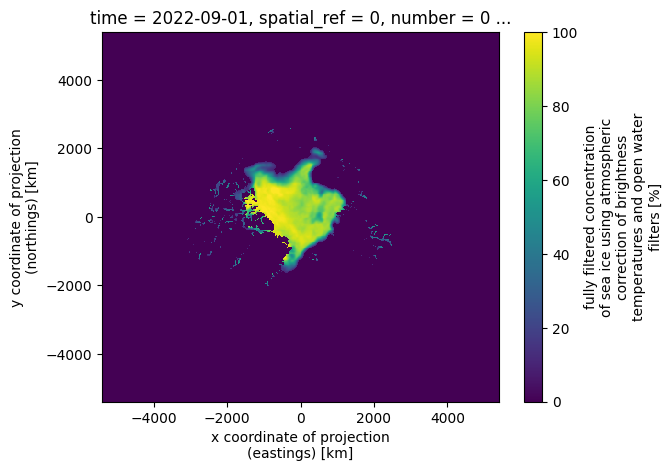

In [ ]:
merged['concentration'].sel(time=pd.to_datetime('2022-09-01')).plot()

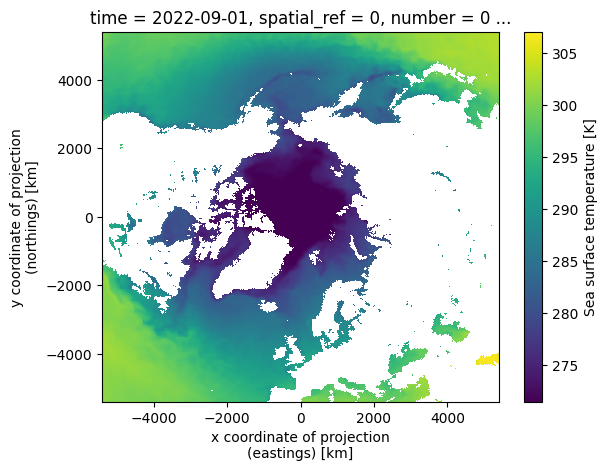

In [ ]:
merged['sst'].sel(time=pd.to_datetime('2022-09-01')).plot()

In [ ]:
!pip install zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 25.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=4687aa8e1b86cc304f3fca4030f3ac162e512ed61f444e0031524f403c140f92
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/Arctic\ sea\ ice\ research/Data/sic-and-era5.zarr.tar sic-and-era5.zarr.tar

drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
!tar -xf sic-and-era5.zarr.tar

In [ ]:
import xarray as xr

In [ ]:
data = xr.open_zarr('sic-and-era5.zarr')

In [ ]:
data

<xarray.Dataset>
Dimensions:        (time: 532, yc: 432, xc: 432)
Coordinates:
    lat            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
  * time           (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
  * xc             (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc             (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables: (12/24)
    concentration  (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    extent         (time, yc, xc) int8 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    land           (yc, xc) int8 dask.array<chunksize=(432, 432), meta=np.ndarray>
    msl            (time, yc, xc) float32 dask.array<chunksize=(1, 297, 432), meta=np.ndarray>
    number         int64 ...
    q_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 297, 432), meta=np.ndarray>
    ...             ...
    u10            (time, yc, xc) float32 dask.array<chunksize=(1, 297, 432), meta=np.ndarray>
    u_10hPa        (time, yc, xc) float32 dask.array<chunksize=(1, 297, 432), meta=np.ndarray>
    v10            (time, yc, xc) float32 dask.array<chunksize=(1, 297, 432), meta=np.ndarray>
    valid_time     (time) datetime64[ns] dask.array<chunksize=(532,), meta=np.ndarray>
    z_250hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 297, 432), meta=np.ndarray>
    z_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 297, 432), meta=np.ndarray>

# Loading combined data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/Andrew\ Arctic\ ice\ research/Data/Combined/sic-and-era5.zarr.tar sic-and-era5.zarr.tar

drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
!tar -xf sic-and-era5.zarr.tar

In [ ]:
!pip install zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 81.4 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=436be2c6af59429a58f689a1a70dba020fccdd133e04ad534154f04094a75be0
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [ ]:
# this should speed things up with the groupby and stuff
!pip install flox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.22-py3-none-any.whl size=25844 sha256=d18dfa2ad8dd341a5a24b1e72d8cfb68dda23c4bd430bdc034abf75c91f8ade4
  Stored in directory: /root/.cache/pip/wheels/5b/ce/73/9192b12bb05cc6a44ba159cb733270b1539004037302a42077
Successfully built numpy-groupies


In [ ]:
import xarray as xr

In [ ]:
data = xr.open_zarr('sic-and-era5.zarr').chunk({'time': 1, 'xc': 432, 'yc': 432})

In [ ]:
data

<xarray.Dataset>
Dimensions:        (time: 532, yc: 432, xc: 432)
Coordinates:
    lat            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
  * time           (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
  * xc             (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc             (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables: (12/19)
    concentration  (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    extent         (time, yc, xc) int8 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    land           (yc, xc) int8 dask.array<chunksize=(432, 432), meta=np.ndarray>
    msl            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    q_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    slhf           (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ...             ...
    tp             (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    u10            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    u_10hPa        (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    v10            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    z_250hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    z_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

In [ ]:
data.stack(band=('xc', 'time'))

<xarray.Dataset>
Dimensions:        (yc: 432, band: 229824)
Coordinates:
    lat            (yc, band) float32 dask.array<chunksize=(432, 229824), meta=np.ndarray>
    lon            (yc, band) float32 dask.array<chunksize=(432, 229824), meta=np.ndarray>
  * yc             (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * band           (band) object MultiIndex
  * xc             (band) float64 -5.388e+03 -5.388e+03 ... 5.388e+03 5.388e+03
  * time           (band) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
Data variables: (12/19)
    concentration  (yc, band) float64 dask.array<chunksize=(432, 532), meta=np.ndarray>
    extent         (yc, band) int8 dask.array<chunksize=(432, 532), meta=np.ndarray>
    land           (yc, band) int8 dask.array<chunksize=(432, 229824), meta=np.ndarray>
    msl            (yc, band) float32 dask.array<chunksize=(432, 532), meta=np.ndarray>
    q_500hPa       (yc, band) float32 dask.array<chunksize=(432, 532), meta=np.ndarray>
    slhf           (yc, band) float32 dask.array<chunksize=(432, 532), meta=np.ndarray>
    ...             ...
    tp             (yc, band) float32 dask.array<chunksize=(432, 532), meta=np.ndarray>
    u10            (yc, band) float32 dask.array<chunksize=(432, 532), meta=np.ndarray>
    u_10hPa        (yc, band) float32 dask.array<chunksize=(432, 532), meta=np.ndarray>
    v10            (yc, band) float32 dask.array<chunksize=(432, 532), meta=np.ndarray>
    z_250hPa       (yc, band) float32 dask.array<chunksize=(432, 532), meta=np.ndarray>
    z_500hPa       (yc, band) float32 dask.array<chunksize=(432, 532), meta=np.ndarray>

# Calculating anomalies

To do: this is somewhat wrong, since we don't want to calculate anomalies of land (and maybe also SIC (or extent maybe); or at least keep original SIC or keep the means somewhere else)

In [ ]:
anomalies = data.drop_vars('land').groupby(data.time.dt.month).map(lambda monthly: monthly - monthly.mean('time')).fillna(0)

In [ ]:
%%time
anomalies.to_zarr('sic-and-era5-anomalies.zarr')

CPU times: user 1min 41s, sys: 23.5 s, total: 2min 4s
Wall time: 2min 26s


In [ ]:
anomalies

<xarray.Dataset>
Dimensions:        (time: 532, yc: 432, xc: 432)
Coordinates:
    lat            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
  * time           (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
  * xc             (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc             (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables: (12/18)
    concentration  (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    extent         (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    msl            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    q_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    slhf           (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    sp             (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ...             ...
    tp             (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    u10            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    u_10hPa        (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    v10            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    z_250hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    z_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

In [ ]:
!tar -cf sic-and-era5-anomalies.zarr.tar sic-and-era5-anomalies.zarr

In [ ]:
!du -h sic-and-era5-anomalies.zarr.tar

4.4G	sic-and-era5-anomalies.zarr.tar


In [ ]:
drive.mount('/content/drive')

!cp sic-and-era5-anomalies.zarr.tar drive/MyDrive/2.0\ Arctic\ sea\ ice\ research/DATA\ 2.0/Model\ #2-Andrew/sic-and-era5-anomalies.zarr.tar

drive.flush_and_unmount()

Mounted at /content/drive


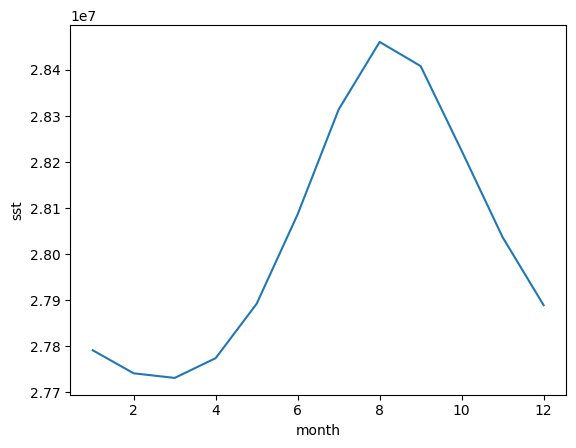

In [ ]:
data['sst'].groupby(data.time.dt.month).map(lambda monthly: monthly.mean('time')).fillna(0).sum(('xc', 'yc')).plot()

# Other plotting

In [ ]:
anomalies

<xarray.Dataset>
Dimensions:        (time: 532, yc: 432, xc: 432)
Coordinates:
  * time           (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
  * xc             (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc             (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat            (yc, xc) float32 dask.array<chunksize=(297, 432), meta=np.ndarray>
    lon            (yc, xc) float32 dask.array<chunksize=(297, 432), meta=np.ndarray>
Data variables: (12/19)
    concentration  (time, yc, xc) float64 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>
    extent         (time, yc, xc) float64 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>
    land           (yc, xc) int8 dask.array<chunksize=(297, 432), meta=np.ndarray>
    msl            (time, yc, xc) float32 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>
    q_500hPa       (time, yc, xc) float32 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>
    slhf           (time, yc, xc) float32 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>
    ...             ...
    tp             (time, yc, xc) float32 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>
    u10            (time, yc, xc) float32 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>
    u_10hPa        (time, yc, xc) float32 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>
    v10            (time, yc, xc) float32 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>
    z_250hPa       (time, yc, xc) float32 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>
    z_500hPa       (time, yc, xc) float32 dask.array<chunksize=(12, 297, 432), meta=np.ndarray>

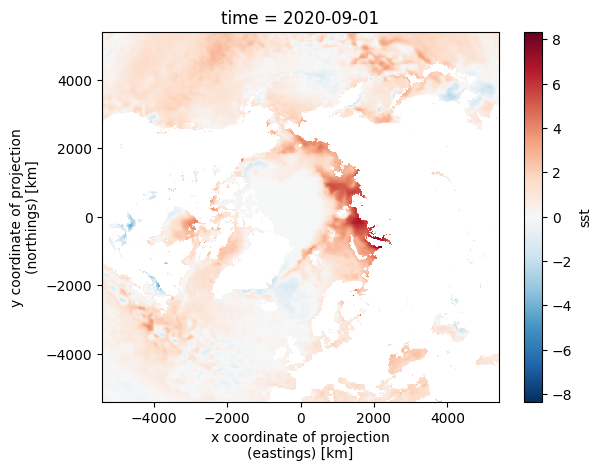

In [ ]:
(data['sst']-data.isel(time=(data.time.dt.month == 9))['sst'].mean('time')).sel(time='2020-09-01').plot()

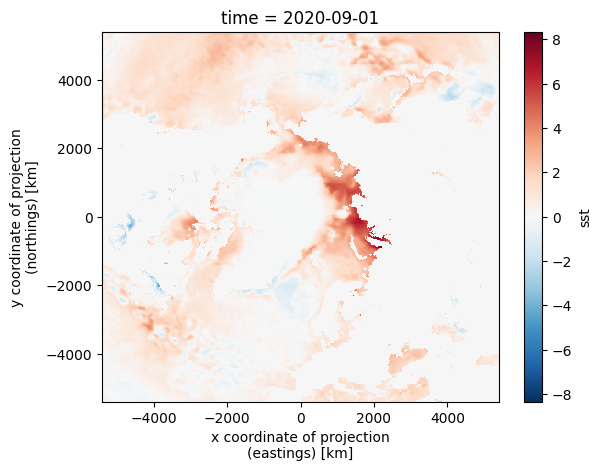

In [ ]:
anomalies['sst'].sel(time='2020-09-01').plot()

# DWT code

In [ ]:
import numpy as np

In [ ]:
# Filter bank for the 3-band 2-regular wavelet
wv32 = (
  ( 0.33838609728386,  0.53083618701374,  0.72328627674361,  0.23896417190576,  0.04651408217589, -0.14593600755399),
  (-0.11737701613483,  0.54433105395181, -0.01870574735313, -0.69911956479289, -0.13608276348796,  0.42695403781698),
  ( 0.40363686892892, -0.62853936105471,  0.46060475252131, -0.40363686892892, -0.07856742013185,  0.24650202866523)
)

# Filter bank for the 4-band 2-regular wavelet
wv42 = (
  (-0.067371764,  0.094195111,  0.40580489 ,  0.567371764,  0.567371764,  0.40580489 ,  0.094195111, -0.067371764),
  (-0.094195111,  0.067371764,  0.567371764,  0.40580489,  -0.40580489 , -0.567371764, -0.067371764,  0.094195111),
  (-0.094195111, -0.067371764,  0.567371764, -0.40580489,  -0.40580489 ,  0.567371764, -0.067371764, -0.094195111),
  (-0.067371764, -0.094195111,  0.40580489 , -0.567371764,  0.567371764, -0.40580489 ,  0.094195111,  0.067371764)
)

# Filter bank for the 4-band 4-regular wavelet
wv44 = (
  ( 0.0857130200,  0.1931394393,  0.3491805097,  0.5616494215,  0.4955029828,  0.4145647737,  0.2190308939, -0.1145361261,
   -0.0952930728, -0.1306948909, -0.0827496793,  0.0719795354,  0.0140770701,  0.0229906779,  0.0145382757, -0.0190928308),
  (-0.1045086525,  0.1183282069, -0.1011065044, -0.0115563891,  0.6005913823, -0.2550401616, -0.4264277361, -0.0827398180,
    0.0722022649,  0.2684936992,  0.1691549718, -0.4437039320,  0.0849964877,  0.1388163056,  0.0877812188, -0.1152813433),
  ( 0.2560950163, -0.2048089157, -0.2503433230, -0.2484277272,  0.4477496752,  0.0010274000, -0.0621881917,  0.5562313118,
   -0.2245618041, -0.3300536827, -0.2088643503,  0.2202951830,  0.0207171125,  0.0338351983,  0.0213958651, -0.0280987676),
  ( 0.1839986022, -0.6622893130,  0.6880085746, -0.1379502447,  0.0446493766, -0.0823301969, -0.0923899104, -0.0233349758,
    0.0290655661,  0.0702950474,  0.0443561794, -0.0918374833,  0.0128845052,  0.0210429802,  0.0133066389, -0.0174753464)
)

In [ ]:
# to do: maybe use numpy more, e.g. np.shape() for the number of bands and filter bank length
def dwt_matrix(filter_banks, rows_per_filter_bank):
  filter_banks = np.array(filter_banks)

  # assertions that may or may not be needed
  num_bands, filter_bank_length = filter_banks.shape
  num_bands = len(filter_banks)
  assert num_bands > 0
  assert filter_bank_length % num_bands == 0 # this is true because an M-band L-regular DWT matrix has M filters with length ML
  # Mk x Mk matrix
  matrix_size = num_bands * rows_per_filter_bank
  assert matrix_size >= filter_bank_length

  shift = num_bands
  res = np.zeros((matrix_size, matrix_size))
  row = 0
  for filter_bank in filter_banks:
    current_offset = 0
    for _ in range(rows_per_filter_bank):
      for (i, value) in enumerate(filter_bank):
        res[row][(current_offset + i) % matrix_size] = value
      current_offset += shift
      row += 1
  return res

def dwt_1d(wavelet, signal):
  num_bands = len(wavelet)
  assert len(signal) % num_bands == 0
  k = len(signal) // num_bands
  matrix = dwt_matrix(wavelet, k)
  values = np.matmul(matrix, signal)
  return np.split(values, num_bands)

def idwt_1d(wavelet, components):
  signal = np.concatenate(components)
  num_bands = len(wavelet)
  assert len(signal) % num_bands == 0
  k = len(signal) // num_bands
  matrix = dwt_matrix(wavelet, k)
  values = np.matmul(np.transpose(matrix), signal)
  return values

# to do: make work only for square images; also vectorize
def dwt_2d(wavelet, signal):
  num_bands = len(wavelet)
  assert len(signal) % num_bands == 0
  x, y = np.shape(signal)
  assert x % num_bands == 0
  assert y % num_bands == 0
  k1 = x // num_bands
  k2 = y // num_bands
  matrix1 = dwt_matrix(wavelet, k1)
  matrix2 = dwt_matrix(wavelet, k2)
  values = np.matmul(matrix1, np.matmul(signal, np.transpose(matrix2)))
  return np.array(tuple(np.split(row, num_bands) for row in np.split(values, num_bands, 1)))

# works for non-square images
def dwt_2d_nonsquare(wavelet, signal):
  num_bands = len(wavelet)
  assert len(signal) % num_bands == 0
  x, y = np.shape(signal)
  assert x % num_bands == 0
  assert y % num_bands == 0
  k1 = x // num_bands
  k2 = y // num_bands
  matrix1 = dwt_matrix(wavelet, k1)
  matrix2 = dwt_matrix(wavelet, k2)
  values = np.matmul(matrix1, np.matmul(signal, np.transpose(matrix2)))
  return np.array(tuple(np.split(row, num_bands) for row in np.split(values, num_bands, 1)))

In [ ]:
def clip_to_size(array, new_x, new_y):
  assert len(array.shape) == 2
  x_size, y_size = array.shape
  assert new_x <= x_size
  assert new_y <= y_size
  min_x = (x_size - new_x) // 2
  min_y = (y_size - new_y) // 2
  return array[min_x : min_x+new_x, min_y : min_y+new_y]

# clip an array to a rectangle (optionally a square) with dimensions divisible by the amount of bands, so that the 2D DWT can be performed on it
def clip(array, num_bands, square=True):
  assert len(array.shape) == 2
  if square:
    min_dimension = min(array.shape)
    new_dimension = (min_dimension // num_bands) * num_bands
    return clip_to_size(array, new_dimension, new_dimension)
  else:
    x, y = array.shape
    new_x = (x // num_bands) * num_bands
    new_y = (y // num_bands) * num_bands
    return clip_to_size(array, new_x, new_y)

# clip a certain amount from each edge of the array
# specific to the output of dwt_2d
def clip_by_amount(array, clip_amt):
  assert len(array.shape) == 4
  _, _, x_size, y_size = array.shape
  return array[:, :, clip_amt : x_size-clip_amt, clip_amt : y_size-clip_amt]

# maybe allow not reclipping on some dimensions after the DWT when it naturally wraps around, e.g. longitude
def clip_and_dwt(wavelet, signal, square=True):
  num_bands, filter_bank_length = np.shape(wavelet)
  clipped = clip(signal, num_bands, square)
  dwted = dwt_2d(wavelet, clipped)
  # remove artifacts at the edge due to wrapping
  # I'm not completely sure that this is the exact amount of the image that is affected by the wrapping
  clipped_2 = clip_by_amount(dwted, filter_bank_length - num_bands)
  return clipped_2

In [ ]:
# approximation and detail components
def a_d_components(wavelet, signal):
  dwted = dwt_1d(wavelet, signal)
  num_bands, k = np.shape(dwted)
  # is there a nicer way to do this?
  return [idwt_1d(wavelet, [part if j == i else np.zeros(k) for j in range(num_bands)]) for i, part in enumerate(dwted)]

In [ ]:
# given a 4D array as the output of dwt_2d, concatenate those images to get a 2D array
def full_decomp(dwted):
  return np.concatenate(np.concatenate(dwted, 1), 1) # what does this do and why is it right?

In [ ]:
import pywt

In [ ]:
wavelets_and_names = []

wavelets_and_names.append((((1,),), 'none')) # wavelet that does nothing

for i in range(1, 6):
  dbi = pywt.Wavelet(f"db{i}").filter_bank[2:4]
  wavelets_and_names.append((dbi, f'db{i}'))

wavelets_and_names.append((wv32, 'wv32'))
wavelets_and_names.append((wv42, 'wv42'))
wavelets_and_names.append((wv44, 'wv44'))

# Perform DWT

In [ ]:
data

<xarray.Dataset>
Dimensions:        (time: 532, yc: 432, xc: 432)
Coordinates:
    lat            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
  * time           (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
  * xc             (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc             (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables: (12/19)
    concentration  (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    extent         (time, yc, xc) int8 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    land           (yc, xc) int8 dask.array<chunksize=(432, 432), meta=np.ndarray>
    msl            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    q_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    slhf           (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ...             ...
    tp             (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    u10            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    u_10hPa        (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    v10            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    z_250hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    z_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

In [ ]:
import dask.array as da

In [ ]:
# takes in a 3D dask array of shape (time, y, x) and outputs a 5D one of shape (time, wy, wx, y, x)
# the time dimension is basically ignored and is for vectorization
# works only for square images
def vectorized_dwt(wavelet, signal):
  num_bands = len(wavelet)
  t, y, x = signal.shape
  assert x == y
  assert x % num_bands == 0
  k = x // num_bands
  matrix = dwt_matrix(wavelet, k)
  #values = np.matmul(np.matmul(matrix, signal), matrix.T)
  values = da.matmul(da.matmul(matrix, signal), matrix.T)
  # the reshape puts it into shape (time, wy, y, wx, x), then transpose to (time, wy, wx, y, x)
  return values.reshape((t, num_bands, k, num_bands, k)).transpose(0, 1, 3, 2, 4).astype(np.float32)
  #return np.array(tuple(np.split(row, num_bands) for row in np.split(values, num_bands, 1)))
  # to do: maybe clip

In [ ]:
%%time

# probably don't actually need to do this in a loop; this is just to see how long it takes

for wavelet, name in wavelets_and_names:
  dwted = xr.apply_ufunc(lambda x: vectorized_dwt(wavelet, x),
                         data.drop_vars(('land', 'sst')), # to do: how to deal with these two? land doesn't work since it doesn't have the time dimension, and sst doesn't since it has missing data.
                         input_core_dims=(('time', 'yc', 'xc'),),
                         output_core_dims=(('time', 'wy', 'wx', 'y', 'x'),),
                         dask='allowed')

CPU times: user 3.26 s, sys: 48.8 ms, total: 3.31 s
Wall time: 3.37 s


In [ ]:
data.load()

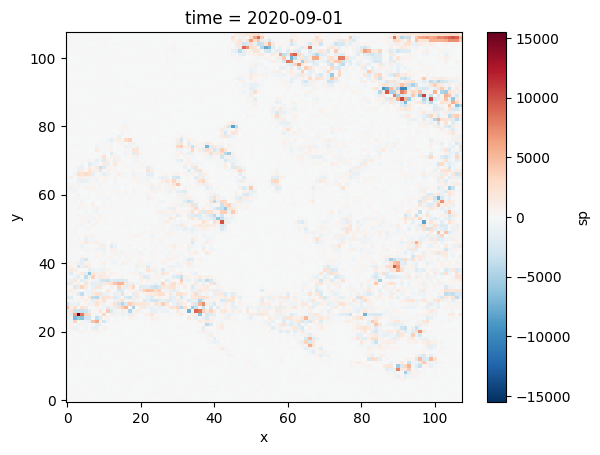

In [ ]:
dwted['sp'].sel(time='2020-09-01').sel(wx=0, wy=1).plot()

To do: make figure for DWT

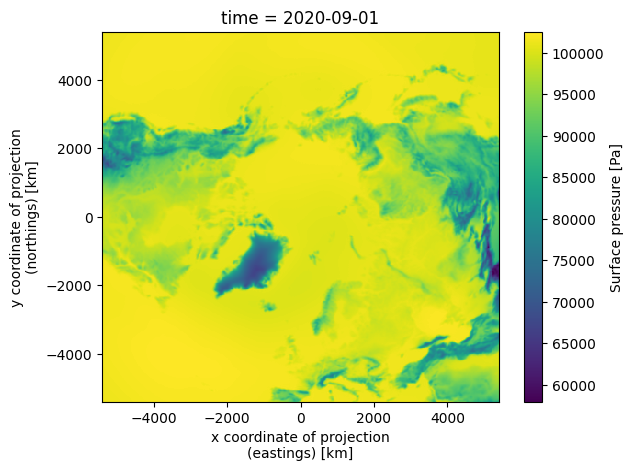

In [ ]:
data['sp'].sel(time='2020-09-01').plot()

In [ ]:
dwted

<xarray.Dataset>
Dimensions:        (time: 532, wy: 4, wx: 4, y: 108, x: 108)
Coordinates:
  * time           (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
Dimensions without coordinates: wy, wx, y, x
Data variables: (12/17)
    concentration  (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    extent         (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    msl            (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    q_500hPa       (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    slhf           (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    sp             (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    ...             ...
    tp             (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    u10            (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    u_10hPa        (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    v10            (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    z_250hPa       (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>
    z_500hPa       (time, wy, wx, y, x) float32 dask.array<chunksize=(1, 4, 4, 108, 108), meta=np.ndarray>

In [ ]:
data

<xarray.Dataset>
Dimensions:        (time: 532, yc: 432, xc: 432)
Coordinates:
    lat            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon            (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
  * time           (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
  * xc             (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc             (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables: (12/19)
    concentration  (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    extent         (time, yc, xc) int8 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    land           (yc, xc) int8 dask.array<chunksize=(432, 432), meta=np.ndarray>
    msl            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    q_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    slhf           (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ...             ...
    tp             (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    u10            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    u_10hPa        (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    v10            (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    z_250hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    z_500hPa       (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

In [ ]:
fake_data = xr.DataArray(np.concatenate((np.zeros((1, 432, 432//2)), np.ones((1, 432, 432//2))), axis=2), dims=('time', 'yc', 'xc'))
fake_dwted = xr.apply_ufunc(lambda x: vectorized_dwt(wv42, x),
                         fake_data,
                         input_core_dims=(('time', 'yc', 'xc'),),
                         output_core_dims=(('time', 'wy', 'wx', 'y', 'x'),),
                         dask='allowed')

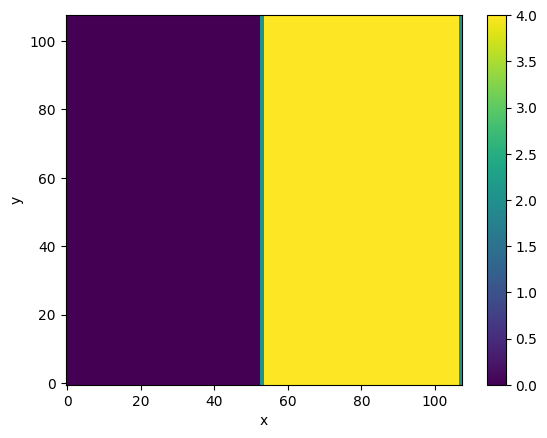

In [ ]:
fake_dwted.sel(wx=0, wy=0).plot()

To do: see if any datasets have no data and don't run DWT on those

Use `data.isnull().any()` to check if there are missing values

Or solve the missing data problem another way

Also to do: vectorize this

In [ ]:
import xarray as xr
import os

In [ ]:
# to do: edit

%%time

os.mkdir('sic-and-era5-dwted')

for wavelet, name in wavelets_and_names:
  dwted = xr.apply_ufunc((lambda x: clip_and_dwt(wavelet, x)), data, exclude_dims=set(('xc', 'yc')), input_core_dims=(('xc', 'yc'),), output_core_dims=(('wx', 'wy', 'x', 'y'),), vectorize=True)
  dwted.to_netcdf(f'sic-and-era5-dwted/{name}.nc')

ValueError: ignored

# UMAP

# Saving the results

...

# Misc unneeded

In [ ]:
# alternative code to generate DWT matrix. I thought it would be faster/simpler but it turns out to be much slower

def dwt_matrix_2(filter_banks, rows_per_filter_bank):
  filter_banks = np.array(filter_banks)

  # assertions that may or may not be needed
  num_bands, filter_bank_length = filter_banks.shape
  num_bands = len(filter_banks)
  assert num_bands > 0
  assert filter_bank_length % num_bands == 0 # this is true because an M-band L-regular DWT matrix has M filters with length ML
  # Mk x Mk matrix
  matrix_size = num_bands * rows_per_filter_bank
  assert matrix_size >= filter_bank_length

  shift = num_bands
  parts = []
  for filter_bank in filter_banks:
    padded_filter_bank = np.pad(filter_bank, (0, matrix_size-filter_bank_length))
    part = np.array([np.roll(padded_filter_bank, shift*i) for i in range(rows_per_filter_bank)])
    parts.append(part)

  return np.concatenate(parts)